# Amplicon Sequence Data Analysis with QIIME 2

Adding ```!``` before the command tells the notebook this is a bash command, rather than python.

To use sequencing data in QIIME2, we first need to turn the FASTQ files containing our data into QIIME artifacts.

What the QIIME2 pipeline will do:
![our workflow](https://github.com/Gibbons-Lab/isb_course_2023/raw/main/docs/16S/assets/steps.png)

### About the Data
I downloaded FASTQ data files generated by [Mr. DNA Lab](https://www.mrdnalab.com/) Molecular Research from DropBox. 
I unzipped the folders and uploaded the `sample-metadata.tsv` file and `demux` folder into the `coral-pae-temp/analysis/microbiome/data` directory.  

Here I am working with the FASTQ data files located in `coral-pae-temp/analysis/microbiome/data/demux`. In the `demux` folder are two `fastq.gz` files for each of the 22 samples, one for the forward read and one for the reverse read. 

The `fastq.gz` file name includes the sample identifier and should look like `4.Ea_S1_L001_R1_001.fastq.gz`. 
The underscore-separated fields in this file name are:

1.  the sample identifier,

2.  the barcode sequence or a barcode identifier,

3.  the lane number,

4.  the direction of the read (i.e. R1 or R2, because these are paired-end reads), and

5.  the set number.
   

The `fastq.gz` files are **Demultiplexed** (aka **Demuxed**) sequences that still have the forward and reverse primers in the sequences.

-   The Raw Data is **demultiplexed**

-   A R1 and R2 fastq.gz file has been generated for each individual sample

-   All forward reads are binned into the R1 fastq.gz files

-   All reverse reads are binned into the R2 fastq.gz files

-   Other than demultiplexing; you can consider the Raw Data on BaseSpace as untouched (**The Forward and Reverse Primer Sequences have not been removed**)

## Python 3 API import qiime plugins

In [1]:
from qiime2 import Visualization
from qiime2 import Artifact
from qiime2.plugins import composition

In [46]:
#pip install empress
#!qiime dev refresh-cache
#!qiime empress --help

Usage: qiime empress [OPTIONS] COMMAND [ARGS]...

  Description: This QIIME 2 plugin wraps Empress and supports interactive
  visualization of phylogenetic trees.

  Plugin website: http://github.com/biocore/empress

  Getting user support: Please post to the QIIME 2 forum for help with this
  plugin: https://forum.qiime2.org

Options:
  --version            Show the version and exit.
  --example-data PATH  Write example data and exit.
  --citations          Show citations and exit.
  --help               Show this message and exit.

Commands:
  community-plot  Visualize phylogenies and community data with Empress (and,
                  optionally, Emperor)
  tree-plot       Visualize phylogenies with Empress


## Take a Look at the Metadata
Make a table of the metadata.
Here I added columns 'Pae', 'Temp', 'PeaTemp', 'Colony', and 'Tank' to the original `sample-metadata.tsv` file provided to me by Mr. DNA and renamed it `sample-metadata-verbose.tsv`
This was a bit of a process... I had to:
upload the `sample-metadata.tsv` to Excel
edit the metadata by adding the above columns and values
save it as a csv
open it in a text editor
search for all ',' commas, and find&replace them with 'TAB' symbols
save as a tab separated file `.tsv`
upload it back into the `coral-pae-temp/analysis/microbiome/rawdata` folder


At first I had named the new columns 'pae', 'temp', etc. with lower case... for some reason this was a problem later on and the interactive emperor plots wouldn't recognize the new columns. When I changed the column names to CamelCase to match the others, it worked. The `qiime2` docs indicate that metadata formatted with an Identifier Column such as `#Sample ID` is [case-sensitive](https://docs.qiime2.org/2023.5/tutorials/metadata/#metadata-formatting-requirements:~:text=feature%2Did-,Case%2Dsensitive,-(these%20are%20mostly)

Later, I realized I could have edited the tsv in python using pandas!

In [38]:
!qiime metadata tabulate \
  --m-input-file ../data/sample-metadata-verbose.tsv \
  --o-visualization ../output/sample-metadata-verbose.qzv

Saved Visualization to: ../output/sample-metadata-verbose.qzv


In [2]:
Visualization.load('../output/sample-metadata-verbose.qzv')

<visualization: Visualization uuid: 8959decd-55e6-4113-94a5-1cea20c31692>

## Generate Filtered Feature Tables

In [24]:
import pandas as pd

### Corals
Only corals samples (remove the blank and mock samples)

In [25]:
# read in tsv sample metadata as a csv
df = pd.read_csv('../data/sample-metadata-verbose.tsv', delimiter='\t')
# make a list of SampleID values to remove
remove = ['blank.', 'mock.']
# remove those rows 
df = df[~df['#SampleID'].isin(remove)]
df

,#SampleID,BarcodeSequence,LinkerPrimerSequence,BarcodeName,ReversePrimer,ProjectName,Description,Pae,Temp,PaeTemp,Colony,Tank
0,1.CA2a,ATCATAGGCT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0073,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.CA2a,control,ambient,control-ambient,1,A2
1,1.CH2a,TGTTAGAAGG,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0074,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.CH2a,control,hot,control-hot,1,H2
2,1.Ea,GATGGATGTA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0075,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.Ea,env,env,env-env,1,KB
3,1.PA2a,ACGGCCGTCA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0076,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.PA2a,peak,ambient,peak-ambient,1,A2
4,1.PH1a,CGTTGCTTAC,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0077,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.PH1a,peak,hot,peak-hot,1,H1
5,2.CA2a,TGACTACATA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0078,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.CA2a,control,ambient,control-ambient,2,A2
6,2.CH1b,CGGCCTCGTT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0079,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.CH1b,control,hot,control-hot,2,H1
7,2.Ea,CAAGCATCCG,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0080,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.Ea,env,env,env-env,2,KB
8,2.PA1b,TCGTCTGACT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0081,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.PA1b,peak,ambient,peak-ambient,2,A1
9,2.PH2a,CTCATAGCGA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0082,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.PH2a,peak,hot,peak-hot,2,H2


In [26]:
# save the new df as a tsv
df.to_csv('../data/sample-metadata-coral.tsv', sep='\t', index=False)

In [5]:
!qiime feature-table filter-samples \
  --i-table ../output/dada2/table.qza \
  --m-metadata-file ../data/sample-metadata-coral.tsv \
  --o-filtered-table ../output/dada2/table-coral.qza

Saved FeatureTable[Frequency] to: ../output/dada2/table-coral.qza


### Treatment
Only treatment samples (remove blank, mock and Environmental control samples)

In [28]:
# read in tsv sample metadata as a csv
df = pd.read_csv('../data/sample-metadata-verbose.tsv', delimiter='\t')
# make a list of SampleID values to remove
remove = ['1.Ea', '2.Ea', '3.Ea', '4.Ea','blank.', 'mock.']
# remove those rows 
df = df[~df['#SampleID'].isin(remove)]
df

,#SampleID,BarcodeSequence,LinkerPrimerSequence,BarcodeName,ReversePrimer,ProjectName,Description,Pae,Temp,PaeTemp,Colony,Tank
0,1.CA2a,ATCATAGGCT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0073,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.CA2a,control,ambient,control-ambient,1,A2
1,1.CH2a,TGTTAGAAGG,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0074,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.CH2a,control,hot,control-hot,1,H2
3,1.PA2a,ACGGCCGTCA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0076,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.PA2a,peak,ambient,peak-ambient,1,A2
4,1.PH1a,CGTTGCTTAC,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0077,GGACTACNVGGGTWTCTAAT,060823STillcus515F,1.PH1a,peak,hot,peak-hot,1,H1
5,2.CA2a,TGACTACATA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0078,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.CA2a,control,ambient,control-ambient,2,A2
6,2.CH1b,CGGCCTCGTT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0079,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.CH1b,control,hot,control-hot,2,H1
8,2.PA1b,TCGTCTGACT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0081,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.PA1b,peak,ambient,peak-ambient,2,A1
9,2.PH2a,CTCATAGCGA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0082,GGACTACNVGGGTWTCTAAT,060823STillcus515F,2.PH2a,peak,hot,peak-hot,2,H2
10,3.CA1b,AGACACATTA,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0083,GGACTACNVGGGTWTCTAAT,060823STillcus515F,3.CA1b,control,ambient,control-ambient,3,A1
11,3.CH2a,GCGCGATGTT,GTGYCAGCMGCCGCGGTAA,60bp_UDPi5_0084,GGACTACNVGGGTWTCTAAT,060823STillcus515F,3.CH2a,control,hot,control-hot,3,H2


In [29]:
# save the new df as a tsv
df.to_csv('../data/sample-metadata-treatment.tsv', sep='\t', index=False)

In [10]:
!qiime feature-table filter-samples \
  --i-table ../output/dada2/table.qza \
  --m-metadata-file ../data/sample-metadata-treatment.tsv \
  --o-filtered-table ../output/dada2/table-treatment.qza

Saved FeatureTable[Frequency] to: ../output/dada2/table-treatment.qza


## Summarize Filtered Feature Tables
After the quality filtering step completes, you’ll want to explore the resulting data. You can do this using the following two commands, which will create visual summaries of the data. The `feature-table summarize` command will give you information on how many sequences are associated with each sample and with each feature, histograms of those distributions, and some related summary statistics. The `feature-table tabulate-seqs` command will provide a mapping of feature IDs to sequences, and provide links to easily BLAST each sequence against the NCBI nt database.

### feature-table summarize
The feature-table summarize command will give you information on how many sequences are associated with each sample and with each feature, histograms of those distributions, and some related summary statistics. Feature tables in QIIME 2 represent the abundance of different biological features (such as bacterial taxa or OTUs) across samples.
 In this command:

--i-table tab.qzal`es the input feature table in QIIME 2 artifact format (.qza file) that you want to sumri

--o-visualizattable.qzv tfies the output visualization in QIIME 2 artifact format (.qzv file) that will con the summaes.

--m-sample-metadata-file sampldata.tsve-cifies the metadata file (usually in tab-separated values format) that contains additional information about the samples in your featble  and m

### All Samples

In [9]:
!qiime feature-table summarize \
  --i-table ../output/dada2/table.qza \
  --o-visualization ../output/dada2/table.qzv \
  --m-sample-metadata-file ../data/sample-metadata-verbose.tsv

Saved Visualization to: ../output/dada2/table.qzv


In [8]:
Visualization.load('../output/dada2/table.qzv')

<visualization: Visualization uuid: 0fd7a87e-1ae2-432e-9489-991cd033d336>

### Coral

In [6]:
!qiime feature-table summarize \
  --i-table ../output/dada2/table-coral.qza \
  --o-visualization ../output/dada/table-coral.qzv \
  --m-sample-metadata-file ../data/sample-metadata-coral.tsv

Saved Visualization to: ../output/dada/table-coral.qzv


In [7]:
Visualization.load('../output/dada/table-coral.qzv')

<visualization: Visualization uuid: d7b2a321-a32a-452f-b3cd-59fdf05e46fd>

## Treatment

In [36]:
!qiime feature-table summarize \
  --i-table ../output/dada2/table-treatment.qza \
  --o-visualization ../output/dada/table-treatment.qzv \
  --m-sample-metadata-file ../data/sample-metadata-treatment.tsv

Saved Visualization to: ../output/dada/table-summary-coral.qzv


## Diversity & Phylogenetics

[Generate a tree for phylogenetic diversity analyses](https://docs.qiime2.org/2023.5/tutorials/moving-pictures-usage/#:~:text=Generate%20a%20tree%20for%20phylogenetic%20diversity%20analyses)

From the moving pictures tutorial:
> QIIME supports several phylogenetic diversity metrics, including Faith’s Phylogenetic Diversity and weighted and unweighted UniFrac. In addition to counts of features per sample (i.e., the data in the FeatureTable[Frequency] QIIME 2 artifact), these metrics require a rooted phylogenetic tree relating the features to one another. This information will be stored in a Phylogeny[Rooted] QIIME 2 artifact. To generate a phylogenetic tree we will use align-to-tree-mafft-fasttree pipeline from the q2-phylogeny plugin. 
First, the pipeline uses the mafft program to perform a multiple sequence alignment of the sequences in our FeatureData[Sequence] to create a FeatureData[AlignedSequence] QIIME 2 artifact. Next, the pipeline masks (or filters) the alignment to remove positions that are highly variable. These positions are generally considered to add noise to a resulting phylogenetic tree. Following that, the pipeline applies FastTree to generate a phylogenetic tree from the masked alignment. The FastTree program creates an unrooted tree, so in the final step in this section midpoint rooting is applied to place the root of the tree at the midpoint of the longest tip-to-tip distance in the unrooted tree.

In [15]:
!qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences ../output/dada/representative_sequences.qza \
  --output-dir ../output/tree

Saved FeatureData[AlignedSequence] to: ../output/tree/alignment.qza
Saved FeatureData[AlignedSequence] to: ../output/tree/masked_alignment.qza
Saved Phylogeny[Unrooted] to: ../output/tree/tree.qza
Saved Phylogeny[Rooted] to: ../output/tree/rooted_tree.qza


In [48]:
!qiime empress tree-plot \
    --i-tree ../output/tree/rooted_tree.qza \
    --o-visualization ../output/tree/empress.qzv

Saved Visualization to: ../output/tree/empress.qzv


In [49]:
Visualization.load("../output/tree/empress.qzv")

<visualization: Visualization uuid: de513a54-510f-430c-94c2-ebfe151b2cbe>

[Diversity](https://docs.qiime2.org/2023.5/tutorials/moving-pictures-usage/#:~:text=Alpha%20and%20beta%20diversity%20analysis)

QIIME 2’s diversity analyses are available through the `q2-diversity` plugin, which supports computing alpha and beta diversity metrics, applying related statistical tests, and generating interactive visualizations. We’ll first apply the `core-metrics-phylogenetic` method, which rarefies a `FeatureTable Frequency` to a user-specified depth, computes several alpha and beta diversity metrics, and generates principle coordinates analysis (PCoA) plots using Emperor for each of the beta diversity metrics.

An important metric to consider when studying microbial ecology is __diversity__. Diversity comes in two flavors: ⍺ (alpha) and β (beta).

Alpha diversity is pretty simple - how diverse is a single sample? You might consider measures like richness and evenness.

![alpha diversity](https://gibbons-lab.github.io/isb_course_2023/16S/assets/alpha_diversity.png)

Beta diversity instead looks at how different two samples are from each other - what taxa are shared, and how their abundances differ.

![beta diversity](https://gibbons-lab.github.io/isb_course_2023/16S/assets/beta_diversity.png)


The metrics computed by default are:
##### Alpha diversity- 
Shannon’s diversity index (a quantitative measure of community richness- 

Observed Features (a qualitative measure of community richne- s)

Faith’s Phylogenetic Dive**rsity (a qualitative measure of community richness that incorporates phylogenetic relationships between the fea**t- res)

Evenness (or Pielou’s Evenness; a measure of community eve##### nness)

Beta - iversity

Jaccard distance (a qualitative measure of community dis- imilarity)

Bray-Curtis distance (a quantitative measure of community d- ssimilarity)

unweighted U**niFrac distance (a qualitative measure of community dissimilarity that incorporates phylogenetic relationships betwe**e-  the features)

weighted** UniFrac distance (a quantitative measure of community dissimilarity that incorporates phylogenetic relationships bet**ween the features) 

### Sampling Depth

An important parameter that needs to be provided to this code is ` --p-sampling-depth`, which is the even sampling (i.e. rarefaction) depth. Because most diversity metrics are sensitive to different sampling depths across different samples, this script will randomly subsample the counts from each sample to the value provided for this parameter. For am--ple, if you provide `--p-sampling-depth 500`, this step will subsample the counts in each sample without replacement so that each sample in the resulting table has a total count of 500. If the total count for any sample(s) are smaller than this value, those samples will be dropped from the diversity analysis. Choosing this value is tricky. We recommend making your choice by reviewing the information presented in the `table.qzv` file that was created above. Choose a value that is as high as possible (so you retain more sequences per sample) while excluding as few samples as possible.

In [35]:
## open interactive table visualization
Visualization.load('../output/dada/treatment-only-table.qzv')

<visualization: Visualization uuid: 3fb6bd02-ea73-4612-b40b-6e7550f36c21>

Navigate to the interactive sample detail tab
<br>
Move the sampling depth slider as high as you can before excluding any samples 
<br>
We want the sampling depth to be high, while retaining all 22 samples
<br>
This looks like a sampling depth of 10,6727 (09AUG2023, SST) 
<br>
But maybe we exclude the mock community and bring it up to 163971? (15AUG2023, SST)
<br>
... Redoing this with only the 16 samples that were exposed to the treatment ( so we're excluding here the mock and blank and environmental baseline samples)
<br>
In this.. the lowest frequency is 166920 

What value would you choose to pass for --p-sampling-depth? 
- **166900**
How many samples will be excluded from your analysis based on this choice? 
- **none, all 16 treatment samples are retained**
How many total sequences will you be analyzing in the core-metrics-phylogenetic command?
2,670,400 (68.21%) features present across the 16 treatment samples

<br>
The mock community has the fewest features at **107,656** and is our'limiting factor' to increase sample depth.
Why does the blank have so many features! That is not good... 

To account for variations in sampling depth, we'll provide QIIME2 with a cutoff at which rarefy all our samples. Since this randomly selects sequences, your results might look a little different. We'll also pass in our metadata file, so we can keep track how which samples come from each group.

In [37]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ../output/tree/rooted_tree.qza \
  --i-table ../output/dada/treatment-only-table.qza \
  --p-sampling-depth 166900 \
  --m-metadata-file ../data/treatment-only-metadata.tsv \
  --output-dir ../output/diversity-core

Saved FeatureTable[Frequency] to: ../output/diversity-core/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ../output/diversity-core/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ../output/diversity-core/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ../output/diversity-core/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ../output/diversity-core/evenness_vector.qza
Saved DistanceMatrix to: ../output/diversity-core/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ../output/diversity-core/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ../output/diversity-core/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ../output/diversity-core/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ../output/diversity-core/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: ../output/diversity-core/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: ../output/diversity-core/jaccard_pcoa_results.qza
Saved PCoAResu

### Unweighted Unifrac Emperor Plot

In [38]:
Visualization.load('../output/diversity-core/unweighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: 23a4bc4b-e26f-45d4-b49d-60231e9d6a88>

### Weighted Unifrac Emperor Plot

In [39]:
Visualization.load('../output/diversity-core/weighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: 545dd2ee-a159-4601-ab42-7558cd6f804b>

### Jaccard Emperor PLot

In [40]:
Visualization.load('../output/diversity-core/jaccard_emperor.qzv')

<visualization: Visualization uuid: cea316fc-8fa6-461a-8c9f-be039d010013>

### Bray-Curtis Emperor Plot

In [41]:
Visualization.load('../output/diversity-core/bray_curtis_emperor.qzv')

<visualization: Visualization uuid: de674f56-2a32-4b7f-af53-d6a1c83e5030>

## Alpha Diversity
After computing diversity metrics, we can begin to explore the microbial composition of the samples in the context of the sample metadata. This information is present in the sample metadata file `../rawdata/sample-metadata-verbose.tsv`.

We’ll first test for associations between categorical metadata columns and alpha diversity data.
We’ll do that here for the Faith Phylogenetic Diversity (a measure of community richness):

In [11]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity ../output/diversity-core/faith_pd_vector.qza \
  --m-metadata-file ../data/sample-metadata-verbose.tsv \
  --o-visualization ../output/faith-pd-group-significance.qzv

Saved Visualization to: ../output/faith-pd-group-significance.qzv


### Microbial Community Richness: Faith Phylogenetic Diversity

##### 
Which categorical sample metadata columns are most strongly associated with the differences in microbial community richness
Temperature Treatment

##### Are these differences statistically significat?n

Pae
- no significantly different groups

Temp
- ambient (n=12) vs. hot (n=8), pvalue (0.02)
  
PaeTemp
- peak-ambient (n=4) vs. peak-hot (n=4), pvalue (0.04)
- env-ambient (n=4) vs. peak-hot (n=4), pvalue (0.04)

Colony
- no significantly different groups

Tank
- H1 (n=5) vs KB (n=4), pvalue (0.05)
- A2 (n=4) vs H1 (n=5), pvalue (0.05)t?

In [12]:
Visualization.load('../output/faith-pd-group-significance.qzv')

<visualization: Visualization uuid: 44ee901f-a4e2-401f-9ade-3a8acaa83141>

In [14]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity ../output/diversity-core/evenness_vector.qza \
  --m-metadata-file ../data/sample-metadata-verbose.tsv \
  --o-visualization ../output/diversity-core/evenness-group-significance.qzv

Saved Visualization to: ../output/diversity-core/evenness-group-significance.qzv


### Microbial Community Evenness, Alpha diversity , Pielou's Evenness

##### Which categorical sample metadata columns are most strongly associated with the differences in microbial community evenness? 
Nearly everything but Colony.... 
Surprised by one Tank result: H1 vs H2, I wouldn't have expected those to be different.

##### Are these differences statistically significant?
Pae
- control (n=8) vs peak (n=8), pvalue (0.05)
- env (n=4) vs. peak (n=8), pvalue (0.006)

Temp
- ambient (n=12) vs hot (n=8), pvalue (0.02)

PaeTemp
- control-ambient (n=4) vs peak-ambient (n=4), pvalue (0.02)
- control-ambient (n=4) vs peak-hot (n=4), pvalue (0.02)
- env-ambient (n=4) vs peak-ambient (n=4), pvalue (0.02)
- env-ambient (n=4) vs peak-hot (n=4), pvalue (0.02)
  
Colony
- no significantly different groups

Tank
- A1 (n=4) vs H1 (n=5), pvalue (0.02)
- A1 (n=4) vs KB (n=4), pvalue (0.04)
- A2 (n=4) vs H1 (n=5), pvalue (0.02)
- H1 (n=5) vs H2 (n=3), pvalue (0.05)
- H1 (n=5) vs KB (n=4), pvalue (0.01)

In [15]:
Visualization.load('../output/diversity-core/evenness-group-significance.qzv')

<visualization: Visualization uuid: 9b2cf1e0-084e-4925-a2c8-492e6b2e9be9>

let's use the Shannon vector in the output directory to create a visualization of alpha diversity across samples.

In [52]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity ../output/diversity-core/shannon_vector.qza \
    --m-metadata-file ../data/treatment-only-metadata.tsv \
    --o-visualization ../output/diversity-core/alpha_groups.qzv

Saved Visualization to: ../output/diversity-core/alpha_groups.qzv


In [54]:
Visualization.load("../output/diversity-core/alpha_groups.qzv")

<visualization: Visualization uuid: 423d3a09-aa09-4965-b57a-8bc5f83477f0>

## Beta Diversity

Next we’ll analyze sample composition in the context of categorical metadata using PERMANOVA (first described in Anderson (2001)) using the beta-group-significance command. The following commands will test whether distances between samples within a group, such as samples from the same body site (e.g., gut), are more similar to each other then they are to samples from the other groups (e.g., tongue, left palm, and right palm). If you call this command with the --p-pairwise parameter, as we’ll do here, it will also perform pairwise tests that will allow you to determine which specific pairs of groups (e.g., tongue and gut) differ from one another, if any. This command can be slow to run, especially when passing --p-pairwise, since it is based on permutation tests. So, unlike the previous commands, we’ll run beta-group-significance on specific columns of metadata that we’re interested in exploring, rather than all metadata columns to which it is applicable. Here we’ll apply this to our unweighted UniFrac distances, using two sample metadata columns, as follows.

Let's visualize the beta diversity and see how they separate. For this we'll look at weighted UniFrac. 
<br>

We can check for 'significant' separation between samples using PERMANOVA. We can do this with the diversity plugin in QIIME2.

### Adonis Test

In [58]:
!qiime diversity adonis \
    --i-distance-matrix ../output/diversity-core/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file ../data/treatment-only-metadata.tsv \
    --p-formula "Pae" \
    --p-n-jobs 2 \
    --o-visualization ../output/diversity-core/pae_permanova.qzv

Saved Visualization to: ../output/diversity-core/pae_permanova.qzv


In [59]:
Visualization.load("../output/diversity-core/pae_permanova.qzv")

<visualization: Visualization uuid: b7cba362-ead8-4213-8780-6fc8811639fb>

In [60]:
!qiime diversity adonis \
    --i-distance-matrix ../output/diversity-core/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file ../data/treatment-only-metadata.tsv \
    --p-formula "Temp" \
    --p-n-jobs 2 \
    --o-visualization ../output/diversity-core/temp_permanova.qzv

Saved Visualization to: ../output/diversity-core/temp_permanova.qzv


In [61]:
Visualization.load("../output/diversity-core/temp_permanova.qzv")

<visualization: Visualization uuid: 318cfd6a-c8c8-4e25-b6cc-a76dce648a29>

In [62]:
!qiime diversity adonis \
    --i-distance-matrix ../output/diversity-core/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file ../data/treatment-only-metadata.tsv \
    --p-formula "PaeTemp" \
    --p-n-jobs 2 \
    --o-visualization ../output/diversity-core/paetemp_permanova.qzv

Saved Visualization to: ../output/diversity-core/paetemp_permanova.qzv


In [63]:
Visualization.load("../output/diversity-core/paetemp_permanova.qzv")

<visualization: Visualization uuid: 71523d61-5670-453c-a570-f00122241f39>

### Beta-Group Significance

In [65]:
!qiime diversity beta-group-significance \
  --i-distance-matrix ../output/diversity-core/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ../data/treatment-only-metadata.tsv \
  --m-metadata-column Pae \
  --o-visualization ../output/diversity-core/unweighted-unifrac-pae-significance.qzv \
  --p-pairwise

!qiime diversity beta-group-significance \
  --i-distance-matrix ../output/diversity-core/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ../data/treatment-only-metadata.tsv \
  --m-metadata-column Temp \
  --o-visualization ../output/diversity-core/unweighted-unifrac-temp-significance.qzv \
  --p-pairwise

!qiime diversity beta-group-significance \
  --i-distance-matrix ../output/diversity-core/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ../data/treatment-only-metadata.tsv \
  --m-metadata-column PaeTemp \
  --o-visualization ../output/diversity-core/unweighted-unifrac-paetemp-significance.qzv \
  --p-pairwise

Saved Visualization to: ../output/diversity-core/unweighted-unifrac-pae-significance.qzv
Saved Visualization to: ../output/diversity-core/unweighted-unifrac-temp-significance.qzv
Saved Visualization to: ../output/diversity-core/unweighted-unifrac-paetemp-significance.qzv


In [66]:
Visualization.load("../output/diversity-core/unweighted-unifrac-pae-significance.qzv")

<visualization: Visualization uuid: 0bcf1223-2b98-4ce1-bcf4-56813c9c29e7>

In [67]:
Visualization.load("../output/diversity-core/unweighted-unifrac-temp-significance.qzv")

<visualization: Visualization uuid: 029850b5-14c3-4cde-91b7-4f952a27b02d>

In [68]:
Visualization.load("../output/diversity-core/unweighted-unifrac-paetemp-significance.qzv")

<visualization: Visualization uuid: c340c4fe-7e6b-4efb-8b5c-c19f62e16653>

## [Questions to Guide Data Analysis](https://docs.qiime2.org/2023.5/tutorials/atacama-soils/#paired-end-read-analysis-commands:~:text=Questions%20to%20guide%20data%20analysis)
What sample metadata or combinations of sample metadata are most strongly associated with the differences in microbial composition of the samples? Are these associations stronger with unweighted UniFrac or with Bray-Curtis? Based on what you know about these metrics, what does that difference suggest? For exploring associations between continuous metadata and sample composition, the commands `qiime metadata distance-matrix` in combination with `qiime diversity mantel` and `qiime diversity bioenv` will be useful. These were not covered in the Moving Pictures tutorial, but you can learn about them by running them with the `--help` parameter.

## Alpha rarefaction plotting
In this section we’ll explore alpha diversity as a function of sampling depth using the `qiime diversity alpha-rarefaction` visualizer. This visualizer computes one or more alpha diversity metrics at multiple sampling depths, in steps between 1 (optionally controlled with `--p-min-depth`) and the value provided as `--p-max-depth`. At each sampling depth step, 10 rarefied tables will be generated, and the diversity metrics will be computed for all samples in the tables. The number of iterations (rarefied tables computed at each sampling depth) can be controlled with `--p-iterations`. Average diversity values will be plotted for each sample at each even sampling depth, and samples can be grouped based on metadata in the resulting visualization if sample metadata is provided with the `--m-metadata-file` parameter.

In [4]:
!qiime diversity alpha-rarefaction \
  --i-table ../output/dada/treatment-only-table.qza \
  --i-phylogeny ../output/tree/rooted_tree.qza \
  --p-min-depth 10 \
  --p-max-depth  166900 \
  --m-metadata-file ../data/treatment-only-metadata.tsv \
  --o-visualization ../output/diversity-core/alpha-rarefaction.qzv

Saved Visualization to: ../output/diversity-core/alpha-rarefaction.qzv


In [71]:
Visualization.load('../output/diversity-core/alpha-rarefaction.qzv')

<visualization: Visualization uuid: 4a2f058a-5984-4b4c-841e-f948a57656b3>

# [Taxonomic Classification](https://docs.qiime2.org/2023.5/tutorials/moving-pictures-usage/#taxonomic-analysis:~:text=and%20bottom%20plots.)

In the next sections we’ll begin to explore the taxonomic composition of the samples, and again relate that to sample metadata. The first step in this process is to assign taxonomy to the sequences in our FeatureData[Sequence] QIIME 2 artifact. We’ll do that using a pre-trained Naive Bayes classifier and the q2-feature-classifier plugin. This classifier was trained on the Greengenes 13_8 99% OTUs, where the sequences have been trimmed to only include 250 bases from the region of the 16S that was sequenced in this analysis (the V4 region, bound by the 515F/806R primer pair). We’ll apply this classifier to our sequences, and we can generate a visualization of the resulting mapping from sequence to taxonomy.

Taxonomic classifiers perform best when they are trained based on your specific sample preparation and sequencing parameters, including the primers that were used for amplification and the length of your sequence reads. Therefore in general you should follow the instructions in Training feature classifiers with q2-feature-classifier to train your own taxonomic classifiers. We provide some common classifiers on our data resources page, including Silva-based 16S classifiers, though in the future we may stop providing these in favor of having users train their own classifiers which will be most relevant to their sequence data.

We can learn a lot from diversity metrics, alpha and beta. But to really dig into the data, we need to know what microbes are in each sample 🦠. To do this, we'll classify the reads in QIIME2 using a Bayesian classifier. Several such classifiers are available at https://docs.qiime2.org/2023.9/data-resources/#taxonomy-classifiers-for-use-with-q2-feature-classifier

In [ ]:
!pip install wget
import wget

In [78]:
# Specify the directory where you want to save the downloaded file
output_directory = '../data/taxonomy-classifiers/'

# Download the file and save it to the specified directory
wget.download('https://data.qiime2.org/2023.9/common/silva-138-99-nb-classifier.qza', out=output_directory)
wget.download('https://data.qiime2.org/2023.9/common/silva-138-99-515-806-nb-classifier.qza', out=output_directory)

100% [......................................................................] 148294965 / 148294965

'../data/taxonomy-classifiers//silva-138-99-515-806-nb-classifier.qza'

In [ ]:
# other potential taxonomy classifiers to get/try?
https://data.qiime2.org/2023.9/common/silva-138-99-nb-classifier.qza
https://data.qiime2.org/2023.9/common/silva-138-99-515-806-nb-classifier.qza
https://data.qiime2.org/classifiers/greengenes/gg_2022_10_backbone_full_length.nb.qza
https://data.qiime2.org/classifiers/greengenes/gg_2022_10_backbone.v4.nb.qza
http://ftp.microbio.me/greengenes_release/2022.10/

In [79]:
!qiime feature-classifier classify-sklearn \
    --i-reads ../output/dada/representative_sequences.qza \
    --i-classifier ../data/taxonomy-classifier/silva-138-99-515-806.qza \
    --p-n-jobs 2 \
    --o-classification ../output/taxon/taxa.qza

Usage: qiime feature-classifier classify-sklearn [OPTIONS]

  Classify reads by taxon using a fitted classifier.

Inputs:
  --i-reads ARTIFACT FeatureData[Sequence]
                         The feature data to be classified.         [required]
  --i-classifier ARTIFACT
    TaxonomicClassifier  The taxonomic classifier for classifying the reads.
                                                                    [required]
Parameters:
  --p-reads-per-batch VALUE Int % Range(1, None) | Str % Choices('auto')
                         Number of reads to process in each batch. If "auto",
                         this parameter is autoscaled to min( number of query
                         sequences / n-jobs, 20000).         [default: 'auto']
  --p-n-jobs INTEGER     The maximum number of concurrently worker processes.
                         If -1 all CPUs are used. If 1 is given, no parallel
                         computing code is used at all, which is useful for
                       

In [82]:
!qiime feature-classifier classify-sklearn \
    --i-reads ../output/dada/representative_sequences.qza \
    --i-classifier ../data/taxonomy-classifiers/silva-138-99-515-806-nb-classifier.qza \
    --p-n-jobs 2 \
    --output-dir ../output/taxonomy

Saved FeatureData[Taxonomy] to: ../output/taxonomy/classification.qza


In [84]:
!qiime taxa barplot \
    --i-table ../output/dada/table.qza \
    --i-taxonomy ../output/taxonomy/classification.qza \
    --m-metadata-file ../data/sample-metadata-verbose.tsv \
    --o-visualization ../output/taxonomy/taxa_barplot.qzv

Saved Visualization to: ../output/taxonomy/taxa_barplot.qzv


In [85]:
Visualization.load("../output/taxonomy/taxa_barplot.qzv")

<visualization: Visualization uuid: ccbc0262-b65c-4916-a540-e5e0f51e9fef>

Next Steps:
<br>
- Filter all the bacteria that showed up in the 'blank' sample out of the treatment samples
<br>
- How do I interpret/integrate the mock community?
<br>
- Remove chloroplasts
<br>
- I want to know which taxa are uniquely present in each treatment, and which ones stay the same
 - ANCOM, composition plugin (apply ANalysis of Composition of Microbiomes (ANCOM) to identify features that are differentially abundant across groups
<br>
- Use [PICRUST](https://library.qiime2.org/plugins/q2-picrust2/13/) for functional analysis


## [ZymoBIOMICS Microbial Community Standard](https://www.zymoresearch.com/blogs/blog/zymobiomics-microbial-standards-optimize-your-microbiomics-workflow%20%20%20%20%20%20%20%20)

Analyzing 16S sequencing data of the [ZymoBIOMICS® Standard](https://www.zymoresearch.com/collections/zymobiomics-microbial-community-standards/products/zymobiomics-microbial-community-standard) When sequencing the ZymoBIOMICS® standards analyze them using your regular 16S analysis pipelines, such as Qiime and Mothur. You can compare the measured composition with the theoretical composition of the standard. Questions that should be kept in mind during this comparison include: (1) whether your measurement covers all strains with the proper taxonomy assignment and with correct abundance, (2) whether your measurement indicates the presence of foreign taxa with significant abundance. Taxonomy assignment might be incorrect or improper because of problems in the reference database. Abundance estimation might be off because of bias in DNA extraction, bias in library preparation, poor quality of MiSeq runs, etc. The presence of foreign taxa might indicate process contamination, poor sequencing quality, PCR chimera in library preparation, defects in bioinformatics analysis, defects in reference database, etc. Both the ZymoBIOMICS®Microbial Community Standard and the DNA Standard are certified to have low impurities levels, < 0.01% by DNA abundance. So any foreign taxa with abundance higher than 0.01% are derived from artifacts in your workflow.

Checkout this Zymo resource page on [How to quantify bias with mock microbial community standards](https://www.zymoresearch.com/blogs/blog/how-to-quantify-bias-with-mock-microbial-community-standards)

Theoretical Composition Based on Genomic DNA: Listeria monocytogenes - 12%, Pseudomonas aeruginosa - 12%, Bacillus subtilis - 12%, Escherichia coli - 12%, Salmonella enterica - 12%, Lactobacillus fermentum - 12%, Enterococcus faecalis - 12%, Staphylococcus aureus - 12%, Saccharomyces cerevisiae - 2%, and Cryptococcus neoformans - 2%.

Measurement Integrity Quotient (MIQ) score
The MIQ score simplifies bias assessment by assigning a score from 0 to 100 and can be interpreted like a grade on a high school exam, with >90 being excellent, 80-89 being good, and so on (Figure 1). This is achieved by measuring the fidelity of measured relative abundances compared to a known input. The MIQ score is presented in a user-friendly report which also includes different plots to visually represent the evaluation. These include radar plots, taxa bar plots, and read fate counts

![example-shotgun-composition-MIQ-score](https://files.zymoresearch.com/images/blog_post-miq_score_figure-2b.png)
![example-shotgun-read-fates](https://files.zymoresearch.com/images/blog_post-miq_score_figure-2c.png)


## ANCOM
<br>

[ANCOM](https://docs.qiime2.org/2023.9/plugins/available/composition/ancom/)
<br>

[ANCOM with Bias Correction](https://docs.qiime2.org/2023.9/plugins/available/composition/ancombc/)
<br>

[This post reply](https://forum.qiime2.org/t/specify-w-cutoff-for-anacom/1844/9?u=mortonjt#:~:text=61-,mortonjt,Jamie%20Morton,-laurenroukia) by Jamie Morton about W (y axis) in ANCOM visualization

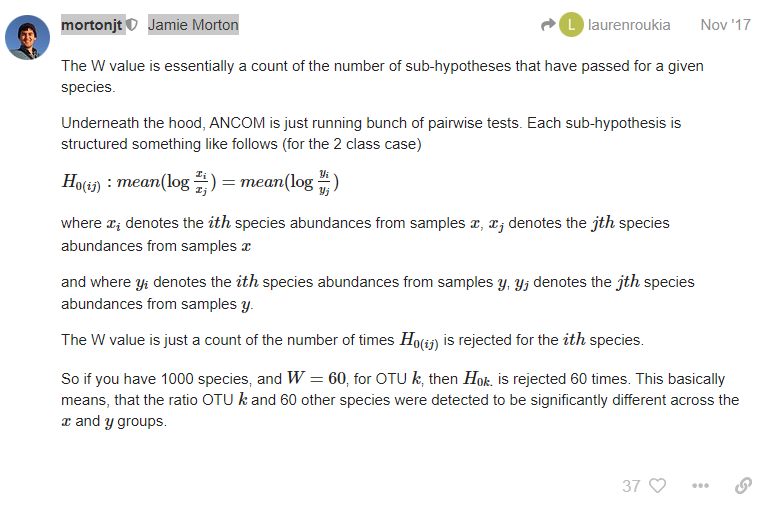
<br>

[This post reply](https://forum.qiime2.org/t/interpreting-values-from-an-ancom-percentile-abundance-table/1497/8?u=mortonjt#:~:text=Hi,%2C) by Greg Caporaso about ANCOM table percentiles

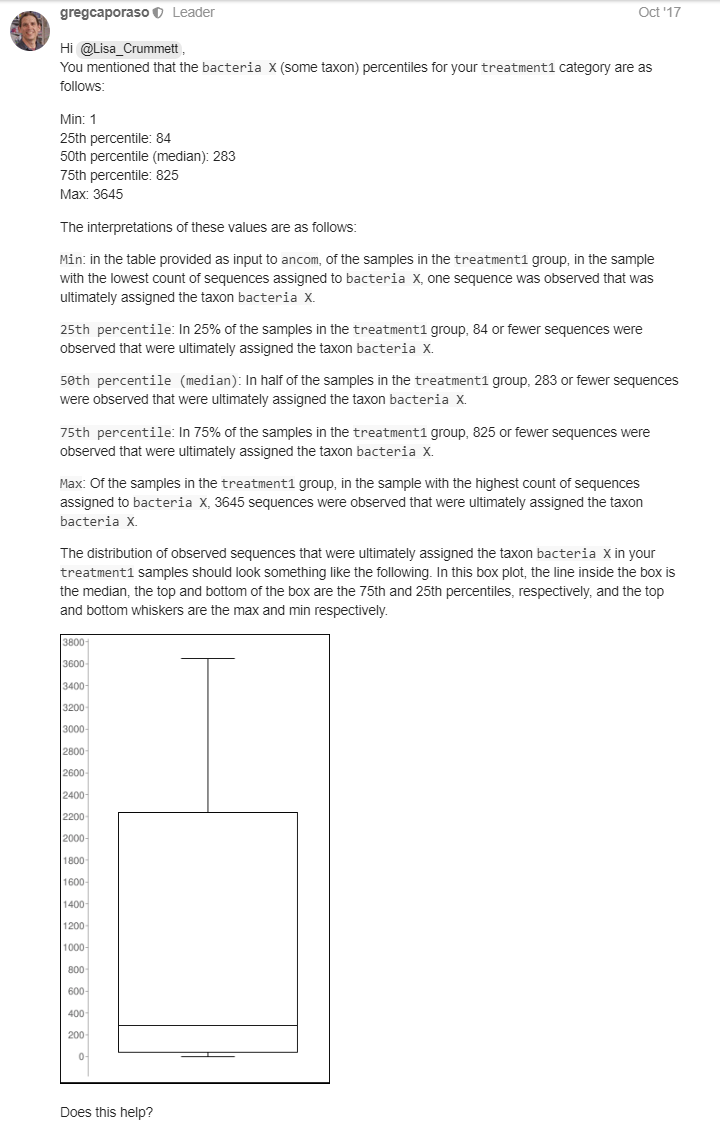

In [5]:
!qiime composition --help

Usage: qiime composition [OPTIONS] COMMAND [ARGS]...

  Description: This QIIME 2 plugin supports methods for compositional data
  analysis.

  Plugin website: https://github.com/qiime2/q2-composition

  Getting user support: Please post to the QIIME 2 forum for help with this
  plugin: https://forum.qiime2.org

Options:
  --version            Show the version and exit.
  --example-data PATH  Write example data and exit.
  --citations          Show citations and exit.
  --help               Show this message and exit.

Commands:
  add-pseudocount  Add pseudocount to table.
  ancom            Apply ANCOM to identify features that differ in abundance.
  ancombc          Analysis of Composition of Microbiomes with Bias Correction
  da-barplot       Differential abundance bar plots
  tabulate         View tabular output from ANCOM-BC.


In [16]:
!qiime composition ancom --help

Usage: qiime composition ancom [OPTIONS]

  Apply Analysis of Composition of Microbiomes (ANCOM) to identify features
  that are differentially abundant across groups.

Inputs:
  --i-table ARTIFACT FeatureTable[Composition]
                       The feature table to be used for ANCOM computation.
                                                                    [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Categorical]
                       The categorical sample metadata column to test for
                       differential abundance across.               [required]
  --p-transform-function TEXT Choices('sqrt', 'log', 'clr')
                       The method applied to transform feature values before
                       generating volcano plots.              [default: 'clr']
  --p-difference-function TEXT Choices('mean_difference', 'f_statistic')
                       The method applied to visualize fold difference in
       

In [17]:
!qiime taxa collapse \
    --i-table ../output/dada/table-coral.qza \
    --i-taxonomy ../output/taxonomy/classification.qza \
    --p-level 6 \
    --o-collapsed-table ../output/taxonomy/collapsed-table-coral-l6.qza 

Saved FeatureTable[Frequency] to: ../output/taxonomy/collapsed-table-coral-l6.qza


In [18]:
!qiime composition add-pseudocount \
    --i-table ../output/taxonomy/collapsed-table-coral-l6.qza \
    --o-composition-table ../output/taxonomy/composition-table-coral-l6.qza

Saved FeatureTable[Composition] to: ../output/taxonomy/composition-table-coral-l6.qza


In [19]:
!qiime composition ancom \
    --i-table ../output/taxonomy/composition-table-coral-l6.qza \
    --m-metadata-file ../data/sample-metadata-coral.tsv \
    --m-metadata-column PaeTemp \
    --o-visualization ../output/taxonomy/ancom-paetemp-coral-l6.qzv

Saved Visualization to: ../output/taxonomy/ancom-paetemp-coral-l6.qzv


In [20]:
Visualization.load("../output/taxonomy/ancom-paetemp-coral-l6.qzv")

<visualization: Visualization uuid: af734e83-4728-4d23-861b-34e5a2783659>

In [17]:
!qiime composition ancom \
    --i-table ../output/taxonomy/composition-table-l6.qza \
    --m-metadata-file ../data/sample-metadata-verbose.tsv \
    --m-metadata-column Pae \
    --o-visualization ../output/taxonomy/ancom-pae-l6.qzv

Saved Visualization to: ../output/taxonomy/ancom-pae-l6.qzv


In [19]:
Visualization.load("../output/taxonomy/ancom-pae-l6.qzv")

<visualization: Visualization uuid: d5afa3f3-1d07-4206-b7a6-baf7e0d2113b>

In [20]:
!qiime composition ancom \
    --i-table ../output/taxonomy/composition-table-l6.qza \
    --m-metadata-file ../data/sample-metadata-verbose.tsv \
    --m-metadata-column Temp \
    --o-visualization ../output/taxonomy/ancom-temp-l6.qzv

Saved Visualization to: ../output/taxonomy/ancom-temp-l6.qzv


In [22]:
Visualization.load("../output/taxonomy/ancom-temp-l6.qzv")

<visualization: Visualization uuid: b5a2c981-117f-44ac-846f-3dc681a9d16d>

## PICRUSt2 
(Phylogenetic Investigation of Communities by Reconstruction of Unobserved States) is a software for predicting functional abundances based only on marker gene sequences.

Checkout the PICRUSt2 Tutorial [here](https://github.com/picrust/picrust2/wiki/PICRUSt2-Tutorial-(v2.5.2)

q2-picrust : Plugin to run the PICRUSt2 pipeline to get EC, KO, and MetaCyc pathway predictions based on 16S data. Either EPA-NG or SEPP can be used to place sequences into the required reference phylogeny.
 

In [ ]:
!conda install q2-picrust2=2023.2 \
-c conda-forge \
-c bioconda \
-c gavinmdouglas 

Retrieving notices: ...working... done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.2
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0



## Package Plan ##

  environment location: /home/shared/8TB_HDD_02/stanja/miniconda3/envs/qiime2-2023.5

  added / updated specs:
    - q2-picrust2=2023.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    coverage-7.3.2             |   py38h01eb140_0         270 KB  conda-forge
    epa-ng-0.3.8               |       hdcf5f2